In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# 0. Preamble

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# notebook_path = '/content/drive/MyDrive/Colab_Notebooks/ISER/code/'
# os.chdir(notebook_path)

In [6]:
data = pd.read_csv("../raw_data/global_crisis_data_country.csv", encoding='unicode_escape')
data.drop(0, inplace = True)
data.shape

(15190, 27)

In [7]:
data.rename(columns={'Banking Crisis ':'banking_crisis',
                    'Systemic Crisis':'systemic_crisis',
                    'Banking_Crisis_Notes':'notes',
                    'Currency Crises':'currency_crisis',
                    'Inflation Crises':'inflation_crisis',
                    'Gold Standard':'gold_standard',
                    'SOVEREIGN EXTERNAL DEBT 1: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom and post-1975 defaults on Official External Creditors': 'sovereign_external_debt_1',
                    'SOVEREIGN EXTERNAL DEBT 2: DEFAULT and RESTRUCTURINGS, 1800-2012--Does not include defaults on WWI debt to United States and United Kingdom but includes post-1975 defaults on Official External Creditors': 'sovereign_external_debt_2',
                    'Inflation, Annual percentages of average consumer prices':'annual_inflation'},
            inplace = True)

data['Year'] = data['Year'].astype(int)

columns_to_convert = ['banking_crisis', 'systemic_crisis', 'annual_inflation', 'currency_crisis', 'inflation_crisis']
data[columns_to_convert] = data[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [8]:
GDP_pc = pd.read_csv('../raw_data/gdp-per-capita-maddison.csv')
GDP_pc.drop(columns='417485-annotations', inplace = True)
GDP_pc.rename(columns={'GDP per capita':'GDP_per_capita'}, inplace = True)

# 1. Selecting countries for global analysis

In [9]:
from dataset import concat_dataset
from dataset import dummy_variable

In [12]:
# List of countries
OECD = ['DEU', 'AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'KOR', 'DNK', 'ESP', 'USA', 'FIN', 'FRA', 'GRC', 'HUN', 'IRL', 'ISL', 'ITA', 'JPN', 'MEX', 'NOR', 'NZL', 'NLD', 'POL', 'PRT', 'GBR', 'SWE', 'CHE', 'TUR']
G7 = ['CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'GBR', 'USA']
G20 = ['DEU', 'CAN', 'FRA', 'GBR', 'JPN', 'ITA', 'USA', 'ZAF', 'SAU', 'RUS', 'CHN', 'ARG', 'BRA', 'IND', 'KOR', 'MEX', 'TUR', 'IDN']
UE = ['DEU', 'FRA', 'AUT', 'BEL', 'DNK', 'ESP', 'NLD', 'POL', 'PRT', 'SWE']
USA = ['USA']

#List for all countries
unique_countries_df1 = set(data['CC3'].unique())
unique_countries_df2 = set(GDP_pc['Code'].unique())
ALL = list(unique_countries_df1.intersection(unique_countries_df2))

#Select a list among those listed above:
countries_selected = G7
#Create a dataset with the data of the countries of the list
global_data = concat_dataset(GDP_pc, data, countries_selected, 'left')
# dummy_variable(global_data)

In [20]:
# Generate a boolean mask where True indicates non-NaN values
not_nan_mask = ~np.isnan(global_data['annual_inflation'])

# Creating a dummy for the years with a banking crisis and no inflation crisis
global_data['banking_crisis_only'] = ((global_data['banking_crisis'] == 1) &
                                    (global_data['inflation_crisis'] != 1) &
                                    (global_data['currency_crisis'] != 1) &
                                    not_nan_mask )
global_data['banking_crisis_only'] = global_data['banking_crisis_only'].astype(int)

#Create a dummy variable for excluded years
global_data['excluded_years'] = ((global_data['inflation_crisis'] == 1) | (global_data['currency_crisis'] == 1)).astype(int)

# Creating a dummy for the first years of crisis
global_data['banking_crisis_only_first_year'] = 0
last_crisis_year = None
previous_year_exlcuded = None
previous_year_inflation_is_nan = None

for index, row in global_data.iterrows():
    if row['banking_crisis'] == 1:
        if row['banking_crisis_only'] == 1 and previous_year_exlcuded != 1 and not previous_year_inflation_is_nan :
            if last_crisis_year is None:
                global_data.at[index, 'banking_crisis_only_first_year'] = 1
            if ((last_crisis_year is not None and row['Year'] - last_crisis_year >= 2) or (last_crisis_year is not None and row['Year'] - last_crisis_year <0)):
                global_data.at[index, 'banking_crisis_only_first_year'] = 1
        last_crisis_year = row['Year']
    previous_year_exlcuded = row['excluded_years']
    previous_year_inflation_is_nan = np.isnan(row['annual_inflation'])

#Create a dummy for recovery period
global_data['recovery_only'] = ((global_data['banking_crisis'] != 1) &
                                (global_data['inflation_crisis'] != 1) &
                                (global_data['systemic_crisis'] != 1) &
                                (global_data['currency_crisis'] != 1) &
                                not_nan_mask)
global_data['recovery_only'] = global_data['recovery_only'].astype(int)

In [31]:
global_data['usable_years'] = 0

# Identify positions where Dummy1 is 1 and Dummy2 is not 1 following two consecutive 1s in Dummy1
mask = (global_data['banking_crisis_only_first_year'] == 1) & ~(global_data['banking_crisis_only_first_year'].shift(1).eq(1) & global_data['excluded_years'].eq(1))

# Set the values of Dummy3 at identified positions to 1
global_data.loc[mask, 'usable_years'] = 1

In [21]:
# global_data['usable_years'] = (global_data['banking_crisis_only_first_year'] == 1) & ~(global_data['banking_crisis_only_first_year'].shift(1).eq(1) & global_data['excluded_years'].eq(1))


In [42]:
banking_crisis_only_first_year = global_data[global_data['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list
print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')
banking_crisis_only_first_year

In this approch, we record 65 different crisis event.


[1873,
 1906,
 1912,
 1923,
 1983,
 1802,
 1805,
 1827,
 1838,
 1848,
 1867,
 1881,
 1889,
 1907,
 1930,
 1994,
 2008,
 1857,
 1880,
 1901,
 1929,
 1977,
 2008,
 1866,
 1889,
 1891,
 1893,
 1907,
 1914,
 1930,
 1935,
 1990,
 2008,
 1872,
 1882,
 1901,
 1907,
 1923,
 1927,
 1992,
 1811,
 1814,
 1825,
 1837,
 1847,
 1857,
 1866,
 1878,
 1890,
 1908,
 1974,
 1991,
 1995,
 2007,
 1817,
 1825,
 1837,
 1841,
 1857,
 1861,
 1873,
 1884,
 1907,
 1984,
 2007]

In [23]:
from functions import compute_crisis_duration
from functions import length_frequency

In [24]:
crisis_duration = compute_crisis_duration(global_data)
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,33,65
1,2,13,32
2,3,8,19
3,4,4,11
4,5,1,7
5,6,1,6
6,7,2,5
7,8,2,3
8,10,1,1


# 2. Extracting inflation series

In [36]:
# from functions import extract_inflation_series
from functions import normalize_crisis_data

In [45]:
def extract_inflation_series(data):
    ''' We want here to return the series of the inflaion rate for each first year of crisis until an inflation crisis happen or another banking crisis occurs.'''
    series = []
    current_serie = []

    for index, row in data.iterrows():
        if not pd.isna(row['annual_inflation']):
        # Extract the serie only if the value of the inflation rate is not a NaN value
            if row['banking_crisis_only_first_year'] == 1:
                # Extract data during a crisis
                if index - 1 >= 0:
                    current_serie.append(data.at[index - 1, 'annual_inflation'])
                current_serie.append(row['annual_inflation'])
                for i in range(1,9):
                    if data.at[index + i, 'banking_crisis_only_first_year'] == 1:
                        break
                    elif data.at[index + i, 'inflation_crisis'] == 1  or pd.isna(data.at[index + i,'annual_inflation']) or data.at[index + i, 'currency_crisis'] == 1 or (data.at[index + i, 'banking_crisis_only_first_year'] == 1):
                        current_serie = []
                        break
                    current_serie.append(data.at[index + i,'annual_inflation'])
                if len(current_serie)>0:
                    series.append(current_serie)
                current_serie = []
    return series

In [47]:
inflation_series = extract_inflation_series(global_data)
norm_inflation_series = normalize_crisis_data(inflation_series)
len(inflation_series)

45

## 2.1 Inflation response to each year of crisis

In [ ]:
from visualisation import plot_by_crisis_length
from visualisation import compute_pattern

33


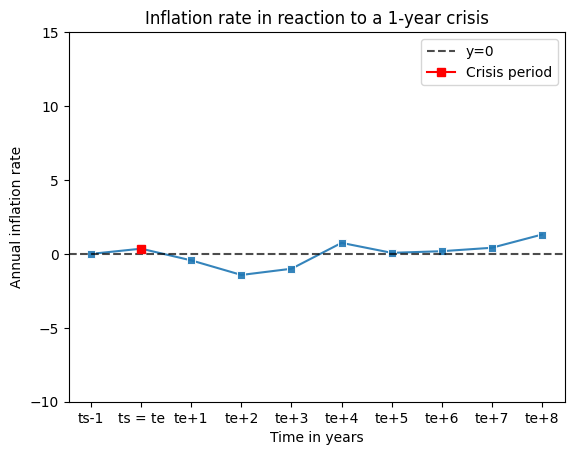

13


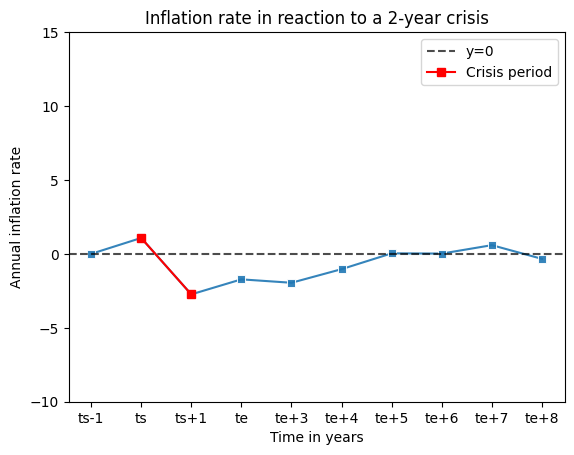

8


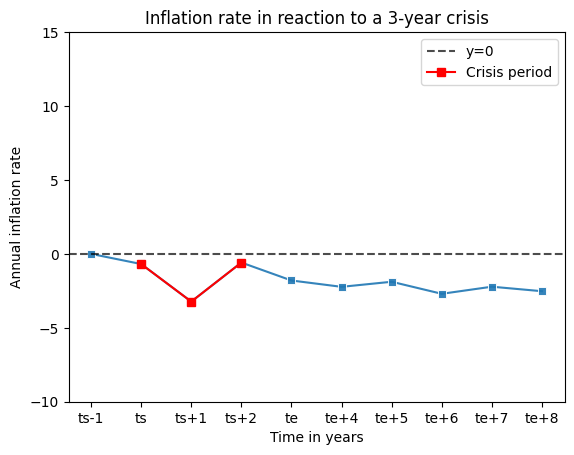

4


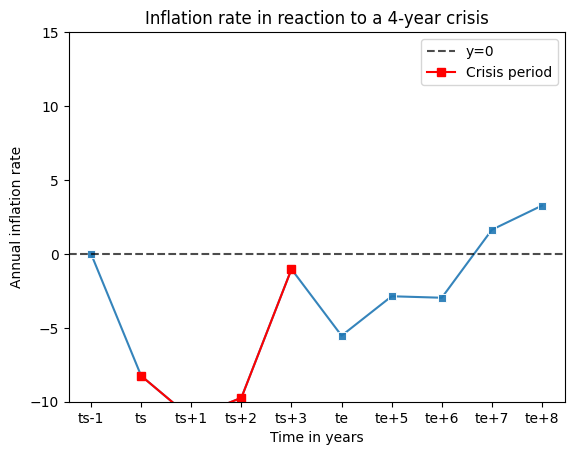

1


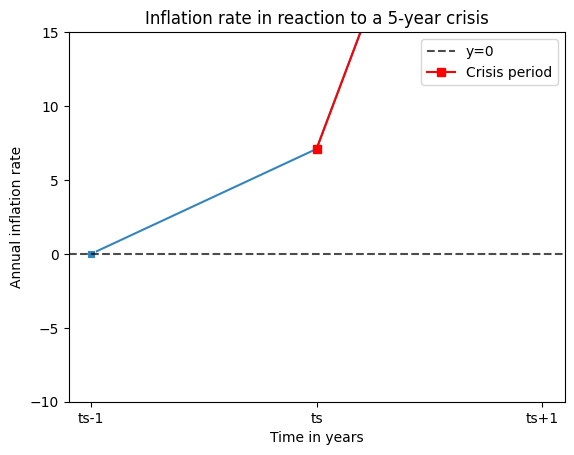

1


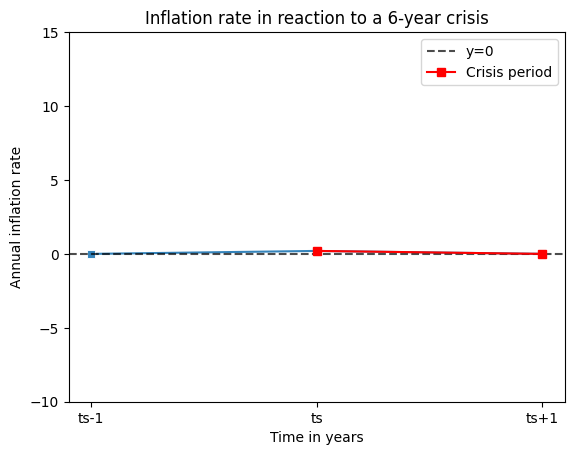

2


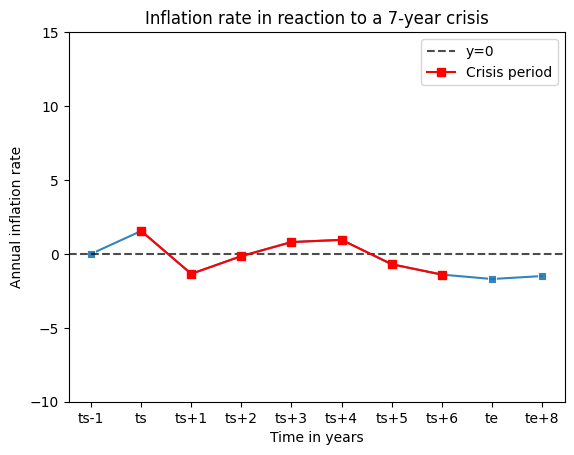

2


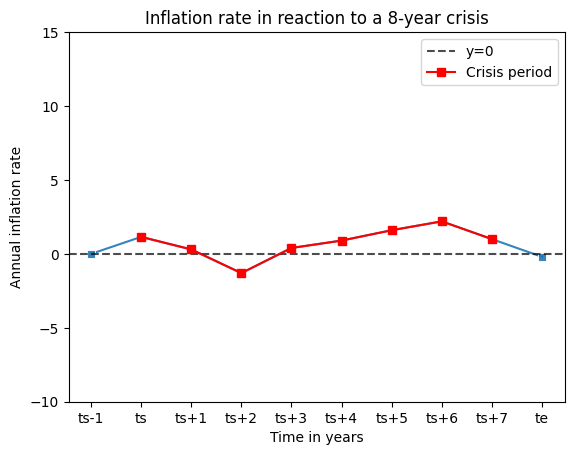

1


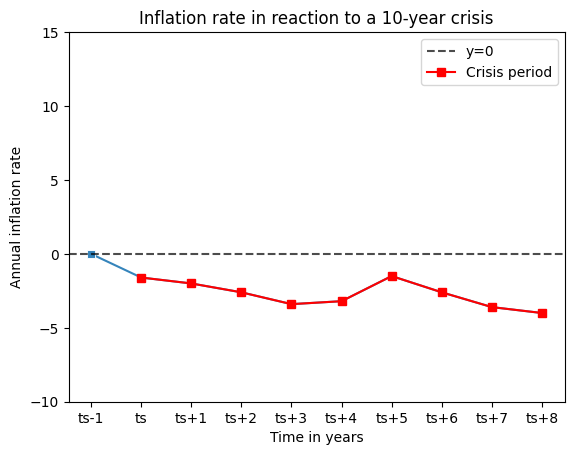

In [ ]:
plot_by_crisis_length(norm_inflation_series, crisis_duration, len_freq, 'Inflation rate')

# 3. Extracting output gap series

In [ ]:
from functions import extract_output_gap_series

In [ ]:
global_data_inner = concat_dataset(GDP_pc, data, countries_selected, 'inner')
dummy_variable(global_data_inner)
global_data_inner

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
0,9.0,CAN,Canada,1820,0.0,NaN,0.0,0,0.2627,NaN,...,NaN,NaN,0,0,0.0,-23.14,0,0,0,0
1,9.0,CAN,Canada,1830,0.0,NaN,0.0,0,0.2465,NaN,...,NaN,NaN,0,0,0.0,-18.82,0,0,0,0
2,9.0,CAN,Canada,1840,0.0,NaN,0.0,0,0.2561,NaN,...,NaN,NaN,0,0,0.0,-9.75,0,0,0,0
3,9.0,CAN,Canada,1850,0.0,NaN,0.0,0,0.2566,NaN,...,NaN,NaN,0,0,0.0,-0.92,0,0,0,0
4,9.0,CAN,Canada,1860,0.0,NaN,0.0,1,0.9902,NaN,...,NaN,NaN,0,0,0.0,3.91,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,66.0,USA,United States,2012,0.0,NaN,0.0,0,1.6251,NaN,...,0,2.1,1,0,0.0,-2.14,0,0,0,1
1304,66.0,USA,United States,2013,0.0,NaN,0.0,0,1.6556,NaN,...,0,1.5,1,0,0.0,-2.22,0,0,0,1
1305,66.0,USA,United States,2014,0.0,NaN,0.0,0,1.5573,NaN,...,0,1.6,1,0,0.0,-1.66,0,0,0,1
1306,66.0,USA,United States,2015,NaN,NaN,0.0,0,1.4738,NaN,...,0,0.1,1,0,NaN,-0.88,0,0,0,1


In [ ]:
global_data_inner[(global_data_inner['Country']=='Japan') & (global_data_inner['Year'] > 1920)]

,Case,CC3,Country,Year,banking_crisis,notes,systemic_crisis,gold_standard,exch_usd,exch_usd_alt1,...,<,annual_inflation,Independence,currency_crisis,inflation_crisis,output_gap,banking_crisis_only,excluded_years,banking_crisis_only_first_year,recovery_only
778,34.0,JPN,Japan,1921,0.0,NaN,0.0,0,2.0867,NaN,...,0,-2.2,1,0,0.0,4.41,0,0,0,1
779,34.0,JPN,Japan,1922,0.0,NaN,0.0,0,2.0471,NaN,...,0,-1.5,1,0,0.0,2.45,0,0,0,1
780,34.0,JPN,Japan,1923,1.0,NaN,0.0,0,2.1272,NaN,...,0,1.0,1,0,0.0,0.62,1,0,1,0
781,34.0,JPN,Japan,1924,0.0,NaN,0.0,0,2.6015,NaN,...,0,2.0,1,1,0.0,1.15,0,1,0,0
782,34.0,JPN,Japan,1925,0.0,NaN,0.0,0,2.3152,NaN,...,0,-1.5,1,0,0.0,2.48,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,34.0,JPN,Japan,2012,0.0,NaN,0.0,0,86.55,NaN,...,0,0.0,1,0,0.0,-2.24,0,0,0,1
870,34.0,JPN,Japan,2013,0.0,NaN,0.0,0,105.3,NaN,...,0,0.4,1,1,0.0,-0.83,0,1,0,0
871,34.0,JPN,Japan,2014,0.0,NaN,0.0,0,120.64,NaN,...,0,2.7,1,1,0.0,-1.05,0,1,0,0
872,34.0,JPN,Japan,2015,NaN,NaN,NaN,0,120.27,NaN,...,0,0.8,1,1,0.0,-0.44,0,1,0,0


In [ ]:
banking_crisis_only_first_year = global_data_inner[global_data_inner['banking_crisis_only_first_year'] == 1]['Year'].tolist()  #Appending those years to a list

print(f'In this approch, we record {len(banking_crisis_only_first_year)} different crisis event.')

In this approch, we record 61 different crisis event.


In [ ]:
crisis_duration = compute_crisis_duration(global_data_inner)
len_freq = length_frequency(crisis_duration)
len_freq

,Length,Count,Number of points
0,1,32,61
1,2,12,29
2,3,8,17
3,4,3,9
4,6,1,6
5,7,2,5
6,8,2,3
7,10,1,1


In [ ]:
output_gap_series = extract_output_gap_series(global_data_inner)
len(output_gap_series)

61

In [ ]:
output_gap_series


[[10.01, 15.31, 12.84, 5.77, -5.1, -2.47, -9.66, -4.73, -4.05, 5.52, 6.85],
 [2.7, 8.36, 6.87, -3.42, 2.22, 6.19, 8.42],
 [8.42, 11.22, 11.74, 0.21, 4.55, 14.03],
 [-9.01, -5.01, -5.45, 2.61, 5.64, 13.03, 19.61, 16.04],
 [-3.4, -3.43, -0.73, 1.8, 1.59, 2.53, 4.31, 3.14, 0.13, -4.62, -6.3],
 [1.34, -1.61, -3.03, -1.42, -4.77, -4.33, 2.79, -0.17, -1.15, 0.99, -1.85],
 [-1.74, 1.31, -3.63, 1.67, 2.35, -1.63, 1.83, 3.65, -1.25, -2.65, 6.3],
 [6.3, -1.87, -0.38, -0.08, -3.17, 1.46, -5.0, -2.01, -5.07, -2.24, 1.93],
 [1.07, -6.05, 1.85, 2.27, -5.16, -4.76, 3.35, -5.18, 5.51, 7.63, -2.46],
 [-1.73, 0.69, 3.93, 2.84, 0.15, -2.99, -2.81, -3.46, -3.81],
 [-3.81, -2.83, -1.87, -0.87, 0.25, 0.56, 2.77, -0.82, 2.28, -0.78, 2.4],
 [-0.95, 2.13, 0.11, 2.91, -4.77, 3.16, 10.26, 8.08, -0.82, -1.64, 3.6],
 [20.88, 15.88, 8.07, 0.95, 8.12, 7.04, 4.5],
 [-3.14, -2.77, -2.62, -3.1, -2.64, -0.99, 0.56, 2.61, 2.77, 2.14, 1.3],
 [4.27, 3.07, -1.23, -0.53, 0.33, -0.76, -1.33, -2.33, -2.24, -2.15, -14.17],
 [3.

## 3.1 Output gap response for each length of crisis

32


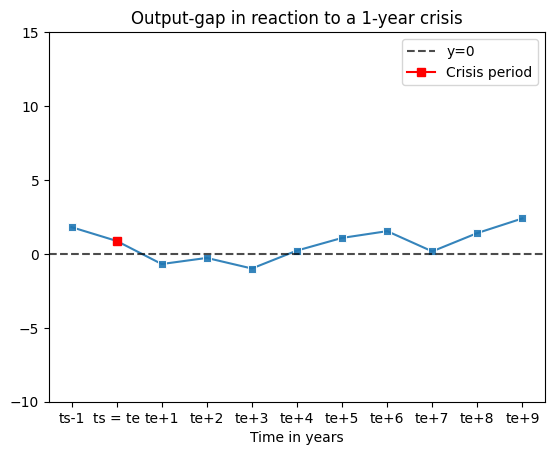

12


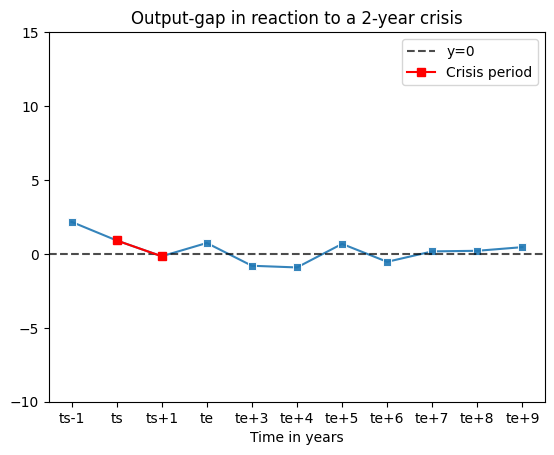

8


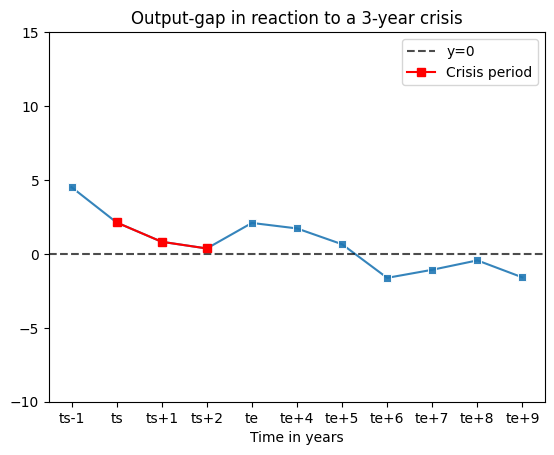

3


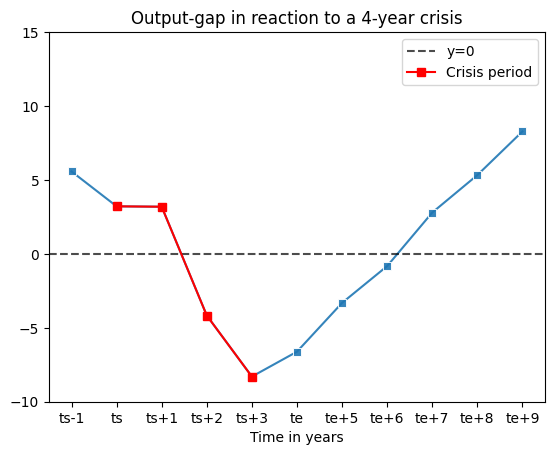

1


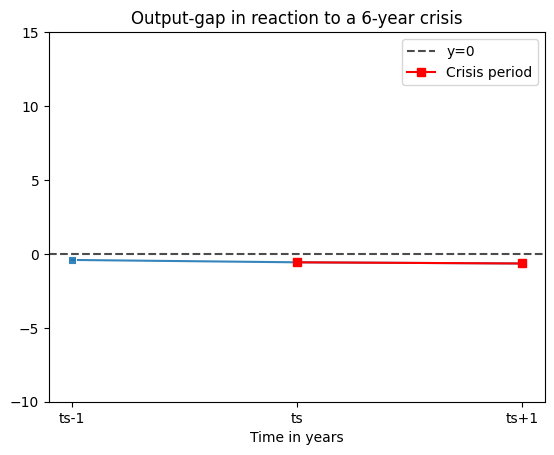

2


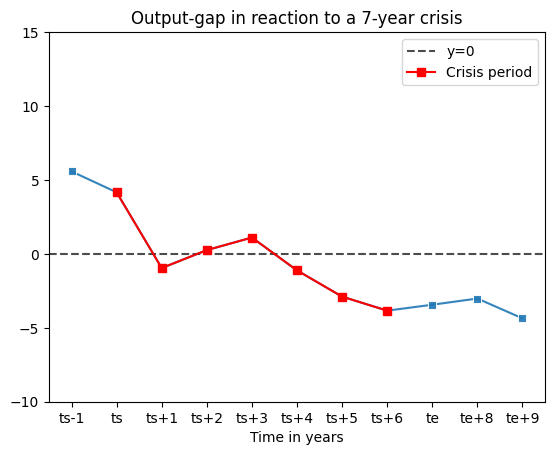

2


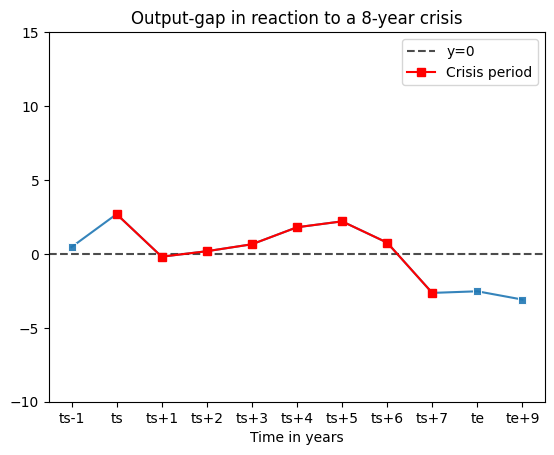

1


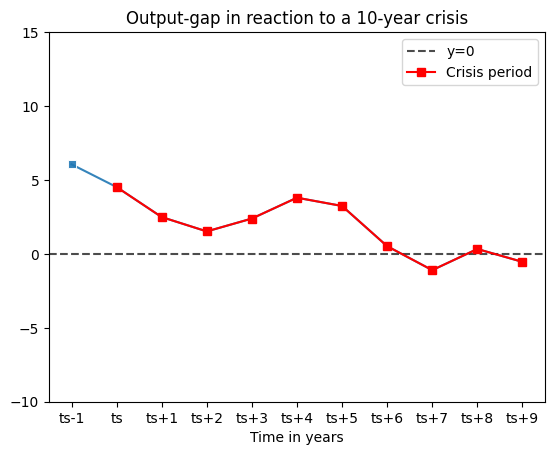

In [ ]:
plot_by_crisis_length(output_gap_series, crisis_duration, len_freq, 'Output-gap')

# 4. Crisis & recovery Dynamics in a multiple country database

In [ ]:
# from functions import inflation_dynamics
from functions import output_gap_dynamics

In [ ]:
from visualisation import plot_dynamics

In [ ]:
def inflation_dynamics(data, during_crisis=True):

    ''' This function is extracting the series of the annual inflation rate for each banking crisis or recovery period.
    Input:
    - dataframe
    - during_crisis = True or False (True for the series each banking crisis, False for the series of each recovery period)
    Output:
    - a list of series

    If during_crisis = True:
        The function extracts the series of the inflation rate for time [Ts-1,..., Te]
        s being the year of the beginning ot the crisis, e being the last year of the crisis.
    If during_crisis = False:
        The function extracts the series of the inflation rate for time [Te+1,..., Ts-1]
        e being the last year of the previous crisis, s being the year of the beginning ot the next crisis.
    '''

    series = []
    crisis_started = False
    recovery_started = False
    first_year_appended = False
    excluded_year_during_crisis = False
    excluded_year_during_recovery = False
    crisis_occured = False
    current_serie = []
    previous_year = 0

    for index, row in data.iterrows():
        # Extract the serie only if the value of the value of the inflation rate is not a NaN value
        if not pd.isna(row['annual_inflation']):
            if during_crisis:
                # Extract data during a crisis
                if row['banking_crisis'] == 1:
                    if not crisis_started:
                        crisis_started = True
                        if row['banking_crisis_only_first_year'] == 1:
                            # Append the inflation rate for the year before the crisis
                            if index - 1 >= 0:
                                current_serie.append(data.at[index - 1, 'annual_inflation'])
                            current_serie.append(row['annual_inflation'])
                            first_year_appended = True
                    else:
                        if row['banking_crisis_only'] == 1 and first_year_appended and not excluded_year_during_crisis:
                            # Continue the existing series
                            current_serie.append(row['annual_inflation'])
                        else:
                            excluded_year_during_crisis = True

                elif crisis_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    crisis_started = False
                    if len(current_serie)>0:
                        series.append(current_serie)
                    current_serie = []
                    first_year_appended = False
                    excluded_year_during_crisis = False
            else:
                # Extract during a non-crisis period
                if row['banking_crisis_only_first_year'] == 1:
                    crisis_occured = True
                elif (row['Year'] - previous_year) < 0:
                    crisis_occured = False

                if row['recovery_only'] == 1:
                    if crisis_occured and not excluded_year_during_recovery:
                        recovery_started = True
                        current_serie.append(row['annual_inflation'])
                elif row['excluded_years'] == 1:
                    excluded_year_during_recovery = True
                elif recovery_started:
                    # End the series when a 0 is recorded in the banking_crisis column
                    recovery_started = False
                    # current_serie = np.array(current_serie)
                    series.append(current_serie)
                    # current_serie = current_serie.tolist()
                    current_serie = []
                    excluded_year_during_recovery = False
                else:
                    excluded_year_during_recovery = False
            previous_year = row['Year']
    return series

In [ ]:
inflation_dynamics(global_data, during_crisis = False)

[[-4.3,
  -3.1,
  -4.6,
  -4.6,
  -2.3,
  6.3,
  2.4,
  2.4,
  -2.0,
  -8.1,
  -2.3,
  -0.8,
  4.1,
  0.1,
  1.9,
  -0.2,
  0.0,
  -3.6,
  -0.2,
  -7.6,
  -2.1,
  -0.1,
  1.4,
  3.8,
  0.0,
  3.6,
  1.6,
  3.7,
  1.6,
  1.1,
  2.4],
 [0.4, 1.2, 1.0, 2.7],
 [1.8, 1.5, 4.4, 14.0],
 [-1.0, 2.7, -0.8, -1.5, -0.1, 1.1],
 [4.2,
  4.4,
  4.1,
  5.0,
  4.8,
  5.6,
  1.5,
  1.9,
  0.1,
  2.2,
  1.6,
  1.6,
  1.0,
  1.7,
  2.7,
  2.5,
  2.3,
  2.7,
  1.8,
  2.2,
  2.0,
  2.1],
 [6.7, -6.3],
 [-2.4, 16.0, 0.4, 2.4, -0.6, 6.4],
 [2.6, -3.4, -1.9, 0.4, -4.1, -0.7, 1.1, 4.7, -4.8],
 [6.3, -2.9, 1.2, -3.5, -1.6, 3.2, 5.3, 5.1],
 [0.0,
  -2.4,
  0.4,
  4.2,
  15.3,
  8.8,
  5.0,
  -1.8,
  -6.3,
  -9.2,
  3.0,
  3.1,
  5.4,
  -5.2,
  1.5,
  -0.5,
  -2.9,
  1.9],
 [-2.5, 1.9, 2.7, 6.3, 0.0, -7.2, -0.9, 1.4, -0.6, -5.1, -0.2, 2.2],
 [-1.1, -4.3, -1.1, 4.0, -6.9, 2.5],
 [-0.7,
  -0.3,
  -4.5,
  -0.7,
  -4.0,
  -2.3,
  -1.2,
  0.1,
  2.9,
  4.1,
  3.8,
  -0.6,
  1.1,
  -1.0,
  -5.4,
  4.4,
  3.6],
 [0.3, 2

In [ ]:
len(inflation_dynamics(global_data, during_crisis = False))

61

65
61


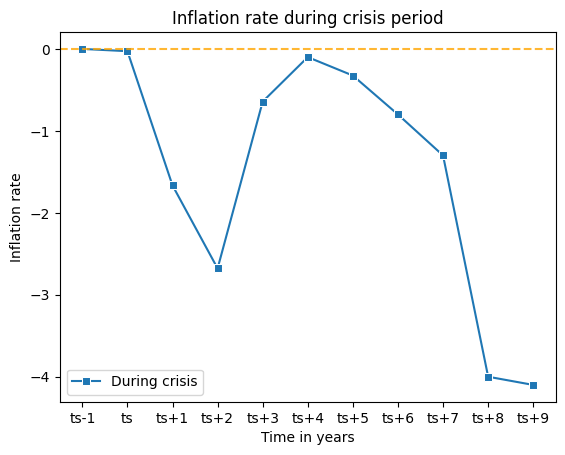

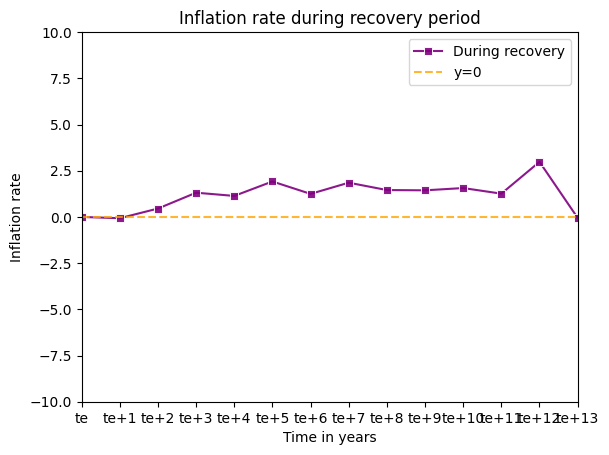

In [ ]:
inflation_crisis_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = True))
inflation_recovery_series = normalize_crisis_data(inflation_dynamics(global_data, during_crisis = False))
print(len(inflation_crisis_series))
print(len(inflation_recovery_series))
plot_dynamics(inflation_crisis_series, inflation_recovery_series, 'Inflation rate')

61
137


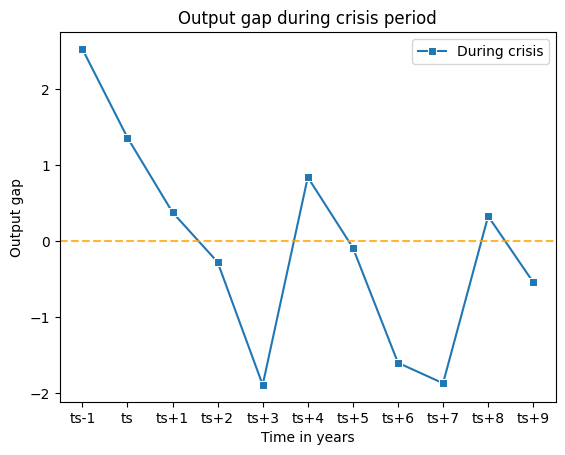

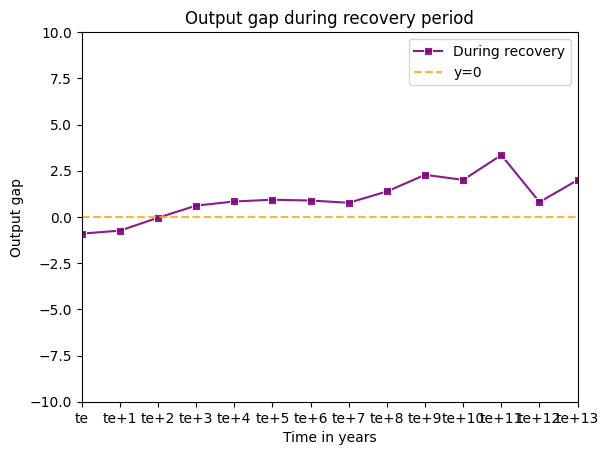

In [ ]:
output_gap_crisis_series = output_gap_dynamics(global_data_inner, during_crisis = True)
output_gap_recovery_series = output_gap_dynamics(global_data_inner, during_crisis = False)
print(len(output_gap_crisis_series))
print(len(output_gap_recovery_series))
plot_dynamics(output_gap_crisis_series, output_gap_recovery_series, 'Output gap')